# Part I: From VGG to ResNet [30 pts]
Implement and compare VGG-16 (Version C) and ResNet-18 for image classification. Explore advanced techniques to improve model performance and the transition from standard deep CNNs to networks with residual connections.
The expected accuracy is above 75% for the base model and 80% for the improved model.

## Step 1: Data preparation

In [1]:
 #added this just since Im using Google Colab, comment it out if you are doing it in VSCode
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
pip install torchmetrics

1. Load CNN dataset.

In [3]:
### ADD YOUR CODE HERE ###
#THIS IS FROM SHIVAM, FOR ABHISHEK MAKE SURE TO CHANEG THIS TO MATCH YOUR PATH
#Shivam
#dataPath = '/content/gdrive/MyDrive/Colab Notebooks/CSE 676 A1 Shivam Abhishek/cnn_dataset'
#Abhishek
'''dataPath = '/content/gdrive/MyDrive/A1_Dataset/cnn_dataset'''


!cp "/content/gdrive/MyDrive/A1_Dataset/cnn_dataset.zip" /content/



In [4]:
#Planning to unzip the files over here , since when i unzipped and uploaded the files on drive
#it gave me a lot of issue regarding bottle neck
!unzip -q /content/cnn_dataset.zip -d /content/


In [5]:
!ls /content

#While unzipping unzipped inside the content path

best_model_he_aug.pth  cnn_dataset	dogs  gdrive	   vehicles
best_vgg16_model.pth   cnn_dataset.zip	food  sample_data


In [6]:
!mkdir -p /content/cnn_dataset

#Created a new folder cnn_dataset so that we can move images inside that

In [7]:
!mv /content/dogs /content/cnn_dataset/
!mv /content/food /content/cnn_dataset/
!mv /content/vehicles /content/cnn_dataset/



mv: cannot move '/content/dogs' to '/content/cnn_dataset/dogs': Directory not empty
mv: cannot move '/content/food' to '/content/cnn_dataset/food': Directory not empty
mv: cannot move '/content/vehicles' to '/content/cnn_dataset/vehicles': Directory not empty


In [8]:
!ls /content/cnn_dataset

#Verifying the folder

dogs  food  vehicles


Analyze the dataset.

In [9]:
import torch, random, numpy as np
SEED = 42
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED)

#Inorder to consistent weights, output of accuracy and loss
#initialising weights here

In [10]:
import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import numpy as np


In [11]:
from torchvision.datasets import ImageFolder
from torchvision import transforms
from collections import Counter

#the transform line below is based on here: https://www.digitalocean.com/community/tutorials/writing-cnns-from-scratch-in-pytorch

transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(), #Normalised pixel values to [0-1] from [0-255], RGB
    #Also normalising now since VGG works better with mean/std
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

dataset = ImageFolder("/content/cnn_dataset", transform=transform)

print("Total images:", len(dataset))
print("Classes:", dataset.classes)
print(Counter(dataset.targets))

Total images: 30000
Classes: ['dogs', 'food', 'vehicles']
Counter({0: 10000, 1: 10000, 2: 10000})


<span style='color:green'>### YOUR ANSWER ###</span>

From the analysis we can see that this dataset has 3 subfoldersm for dogs, food and vehicles. Each of them has 10000 images inside

2.	Create at least three different visualizations to explore the dataset. Provide a short description explaining what each visualization shows.

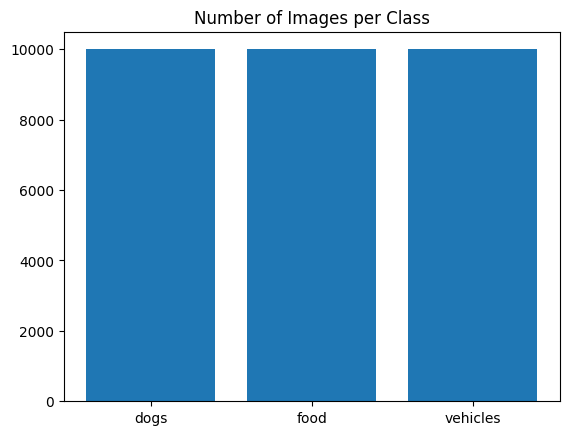

In [12]:
### ADD YOUR CODE HERE ###
#Visualization 1: Number of images per class


import matplotlib.pyplot as plt
from collections import Counter
plt.figure()
count = Counter(dataset.targets)
plt.bar(dataset.classes, count.values())
plt.title('Number of Images per Class')




plt.show()

This bar chart shows the number of images available for each class. As it was previously mentioned we have 3 classes of 10k images per class, thats how the bar graph looks like.

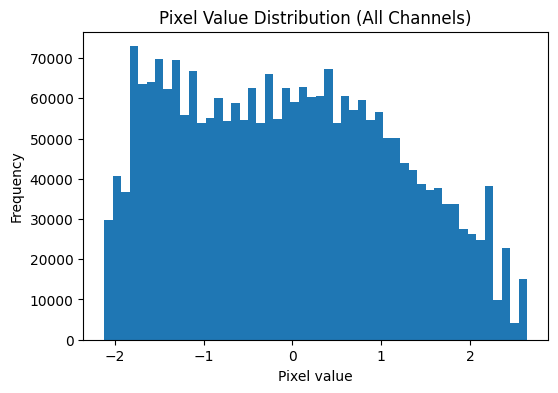

In [13]:
'''#Visualization 2: Histogram of Pixel Values
image, label = dataset[0]
plt.hist(image[0].flatten(), bins=50)
plt.show()'''

import torch

# Take a subset of images
pixels = []

for i in range(200):   # sample first 200 images
    img, _ = dataset[i]
    pixels.append(img.flatten())

pixels = torch.cat(pixels)

plt.figure(figsize=(6,4))
plt.hist(pixels.numpy(), bins=50)
plt.title("Pixel Value Distribution (All Channels)")
plt.xlabel("Pixel value")
plt.ylabel("Frequency")
plt.show()

The above histogram shows the distribution of pixel values in the dataset. We can see that it has been scaled between 0-1 and also if we need we can choose necessary mean / standard deviation if needed for training

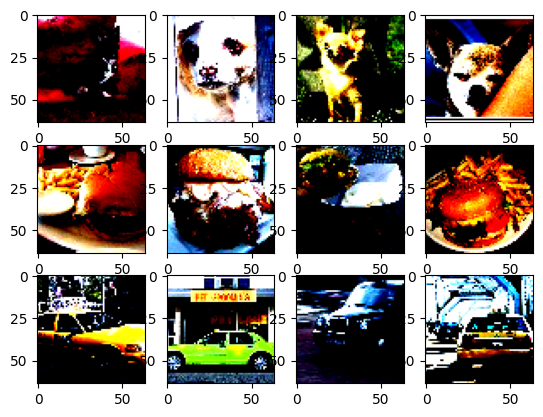

In [14]:

#Visualization 3: grid of sample images
numClasses = len(dataset.classes)
classSamples = {}
for i in range(numClasses):
    classSamples[i] = []

for img, label in dataset:
    if len(classSamples[label]) < 4:
        classSamples[label].append(img)
plt.figure()
plot_index = 1

for class_idx in range(numClasses):
    for img in classSamples[class_idx]:
        plt.subplot(numClasses, 4, plot_index)
        plt.imshow(img.permute(1, 2, 0))
        plot_index += 1

plt.show()


It shows the images present in the different classes, also hughlights the images are not in grey scale and are present in RGB fashion. WE have printed 4 images per class to highlight the different angles or possibilities of how the image has been captured for training . Since we have used normalisation the images shown is clipped, warning but still workable

3. Preprocess the dataset.

In [15]:
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') #Based on here https://www.kaggle.com/code/subhajeetdas/1-pytorch-cuda-check
print(len(dataset.classes))
print(device)


3
cuda


4. Split the dataset into training, testing, and validation sets.

In [16]:
'''### ADD YOUR CODE HERE ###
#Next doing a train-test split of 80-20
trainSet, testSet = torch.utils.data.random_split(dataset, [int(0.8*len(dataset)), len(dataset) - int(0.8*len(dataset))]) #Based on here: https://docs.pytorch.org/docs/stable/data.html#torch.utils.data.random_split
trainLoader = DataLoader(trainSet, batch_size=64, shuffle=True)
testLoader = DataLoader(testSet, batch_size=64, shuffle=True)'''

from torch.utils.data import DataLoader, random_split

dataset_size = len(dataset)
train_size = int(0.70 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size  # To ensure it sums exactly

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

'''train_loader = DataLoader(train_set, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_set, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_set, batch_size=64, shuffle=False, num_workers=4, pin_memory=True)'''

'''print(len(train_loader))
print(len(val_loader))
print(len(test_loader))'''

'print(len(train_loader))\nprint(len(val_loader))\nprint(len(test_loader))'

## Step 2: Implementing VGG

In [17]:
!pip install torchinfo

1. Implement the VGG-16 (Version C) architecture.

In [18]:
### ADD YOUR CODE HERE ###
import torch
import torch.nn as nn

class vgg16(nn.Module):
    def __init__(self, numClasses): #base image is 64*64
        super(vgg16, self).__init__()

        #Start with input channels as 3 and create 64 feature maps  of kernel size 3*3
        self.conv1 = nn.Conv2d(3,64,3,padding=1)
        #Keep the feature maps same
        self.conv2 = nn.Conv2d(64,64,3,padding=1)

        #half the size (64*32*32)
        self.pool1 = nn.MaxPool2d(2,2)


        #Increase the output channels to 128*32*32
        self.conv3 = nn.Conv2d(64,128,3,padding=1)
        self.conv4 = nn.Conv2d(128,128,3,padding=1)

        #Max pool again 128*16*16
        self.pool2 = nn.MaxPool2d(2,2)

        #Conv Block 3
        self.conv5 = nn.Conv2d(128,256,3,padding=1)
        self.conv6 = nn.Conv2d(256,256,3,padding=1)
        self.conv7 = nn.Conv2d(256,256,3,padding=1)

        #Pooling becomes 256*8*8
        self.pool3 = nn.MaxPool2d(2,2)

        # outputs 256x1x1
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))

        #Fully Connected Layers
        self.fc1 = nn.Linear(256*1*1, 512)

        #Convert 512 neurons to 256 features
        self.fc2 = nn.Linear(512, 256)

        #Normally for Vgg16 it is 1000, but since we have 3 classes it will be 3
        self.fc3 = nn.Linear(256, numClasses)


        #Activation function
        self.relu = nn.ReLU()



        #Droput
        self.drop = nn.Dropout(p=0.3)  # reduced dropout for small dataset



    def forward(self, x):

        #Calling relu and conv2d function
        out = self.relu(self.conv1(x))
        #passing the output as the next input for the rest
        out = self.relu(self.conv2(out))
        out = self.pool1(out)

      #passing the output as the next input for the rest
        out = self.relu(self.conv3(out))
        out = self.relu(self.conv4(out))
        out = self.pool2(out)

        #passing the output as the next input for the rest
        out = self.relu(self.conv5(out))
        out = self.relu(self.conv6(out))
        out = self.relu(self.conv7(out))
        out = self.pool3(out)

        #passing the output as the next input for the rest
        out = self.avgpool(out)
        out = torch.flatten(out,1)

        #passing the output as the next input for the rest
        out = self.relu(self.fc1(out))
        out = self.drop(out)

        #passing the output as the next input for the rest
        out = self.relu(self.fc2(out))
        out = self.drop(out)

        #no relu here since it is raw logits
        out = self.fc3(out)



        return out

In [19]:
### ADD YOUR CODE HERE ###
from torchinfo import summary

# Create the model and send it to device
'''model = vgg16(3).to(device)  # 3 classes

# Print model summary for input size 64x64 and batch size 1
summary(model, input_size=(1, 3, 64, 64))'''

#Now creating two objecsts for the model

model_he = vgg16(numClasses=3).to(device)
model_xavier = vgg16(numClasses=3).to(device)

summary(model_he, input_size=(1, 3, 64, 64))


Layer (type:depth-idx)                   Output Shape              Param #
vgg16                                    [1, 3]                    --
├─Conv2d: 1-1                            [1, 64, 64, 64]           1,792
├─ReLU: 1-2                              [1, 64, 64, 64]           --
├─Conv2d: 1-3                            [1, 64, 64, 64]           36,928
├─ReLU: 1-4                              [1, 64, 64, 64]           --
├─MaxPool2d: 1-5                         [1, 64, 32, 32]           --
├─Conv2d: 1-6                            [1, 128, 32, 32]          73,856
├─ReLU: 1-7                              [1, 128, 32, 32]          --
├─Conv2d: 1-8                            [1, 128, 32, 32]          147,584
├─ReLU: 1-9                              [1, 128, 32, 32]          --
├─MaxPool2d: 1-10                        [1, 128, 16, 16]          --
├─Conv2d: 1-11                           [1, 256, 16, 16]          295,168
├─ReLU: 1-12                             [1, 256, 16, 16]       

In [20]:
summary(model_xavier, input_size=(1, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
vgg16                                    [1, 3]                    --
├─Conv2d: 1-1                            [1, 64, 64, 64]           1,792
├─ReLU: 1-2                              [1, 64, 64, 64]           --
├─Conv2d: 1-3                            [1, 64, 64, 64]           36,928
├─ReLU: 1-4                              [1, 64, 64, 64]           --
├─MaxPool2d: 1-5                         [1, 64, 32, 32]           --
├─Conv2d: 1-6                            [1, 128, 32, 32]          73,856
├─ReLU: 1-7                              [1, 128, 32, 32]          --
├─Conv2d: 1-8                            [1, 128, 32, 32]          147,584
├─ReLU: 1-9                              [1, 128, 32, 32]          --
├─MaxPool2d: 1-10                        [1, 128, 16, 16]          --
├─Conv2d: 1-11                           [1, 256, 16, 16]          295,168
├─ReLU: 1-12                             [1, 256, 16, 16]       

2. Use dropout and learning rate scheduler. Experiment with weight initialization strategies.

a) Xavier (Glorot) Initialization

Can be aplied with ReLU or Tanh activations

In [21]:
def weights_init_xavier(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [22]:
# Model with Xavier initialization
model_xavier = vgg16(numClasses=3).to(device)
model_xavier.apply(weights_init_xavier)

vgg16(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=256, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Line

b) He (Kaiming) Initialization

Works well with ReLU activations



In [23]:
def weights_init_he(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

In [24]:
# Model with He initialization
model_he = vgg16(numClasses=3).to(device)
model_he.apply(weights_init_he)

vgg16(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv7): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (avgpool): AdaptiveAvgPool2d(output_size=(1, 1))
  (fc1): Linear(in_features=256, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Line

In [25]:
### ADD YOUR CODE HERE ###
import torch.optim as optim

#Dropout already declared in the vgg model

'''# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
# Learning rate scheduler
sched = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)'''


#The above was decalred but since we would need to experiment with difeerent weights and batch sizes
#its better to have different models



# For model_he
optimizer_he = optim.Adam(model_he.parameters(), lr=0.003, weight_decay=1e-4)
scheduler_he = optim.lr_scheduler.StepLR(optimizer_he, step_size=5, gamma=0.5)

# For model_xavier
optimizer_xavier = optim.Adam(model_xavier.parameters(), lr=0.003, weight_decay=1e-4)
scheduler_xavier = optim.lr_scheduler.StepLR(optimizer_xavier, step_size=5, gamma=0.5)

The goal of weight initialization

Deep networks like VGG16 are very sensitive to initialization.

If weights are too large → activations explode, gradients explode → training fails

If weights are too small → activations vanish, gradients vanish → training is very slow

In [26]:
#SInce the experimenting is required on two differnet batch sizes
train_loader_32 = DataLoader(train_set, batch_size=32, shuffle=True)
val_loader_32 = DataLoader(val_set, batch_size=32, shuffle=True)


train_loader_64 = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader_64 = DataLoader(val_set, batch_size=64, shuffle=True)


print(len(train_loader_32))
print(len(train_loader_64))

657
329


3. Train your VGG-16 model.

In [27]:
def train_model(model, train_loader, val_loader, optimizer, scheduler, epochs=15):
    criterion = nn.CrossEntropyLoss()
    trainAccs, valAccs = [], []
    trainLoss, valLoss = [], []

    for epoch in range(epochs):
        model.train()
        runningLoss, correct, total = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss_val = criterion(out, y)
            loss_val.backward()
            optimizer.step()
            runningLoss += loss_val.item()
            preds = out.argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)

        trainLossEpoch = runningLoss / len(train_loader)
        trainAccEpoch = correct / total
        trainLoss.append(trainLossEpoch)
        trainAccs.append(trainAccEpoch)

        model.eval()
        runningValLoss, correct, total = 0, 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss_val = criterion(out, y)
                runningValLoss += loss_val.item()
                preds = out.argmax(1)
                correct += (preds == y).sum().item()
                total += y.size(0)

        valLossEpoch = runningValLoss / len(val_loader)
        valAccEpoch = correct / total
        valLoss.append(valLossEpoch)
        valAccs.append(valAccEpoch)

        scheduler.step()

        # Print losses and accuracies after every epoch
        print(f"Epoch {epoch+1}: "
              f"TrainLoss={trainLossEpoch:.4f}, ValLoss={valLossEpoch:.4f}, "
              f"TrainAcc={trainAccEpoch:.4f}, ValAcc={valAccEpoch:.4f}")

    return trainLoss, trainAccs, valLoss, valAccs

In [28]:
#WE can have 2 possible combinations with he -> 32,64
#but im taking he with batch size = 32 only
trainLoss_he32, trainAcc_he32, valLoss_he32, valAcc_he32 = train_model(
    model_he,
    train_loader_32,
    val_loader_32,
    optimizer_he,
    scheduler_he,
    epochs=15
)

Epoch 1: TrainLoss=0.8111, ValLoss=0.5027, TrainAcc=0.7040, ValAcc=0.8018
Epoch 2: TrainLoss=0.4265, ValLoss=0.4005, TrainAcc=0.8373, ValAcc=0.8376
Epoch 3: TrainLoss=0.3660, ValLoss=0.2932, TrainAcc=0.8640, ValAcc=0.8958
Epoch 4: TrainLoss=0.3227, ValLoss=0.3140, TrainAcc=0.8826, ValAcc=0.8840
Epoch 5: TrainLoss=0.3060, ValLoss=0.2856, TrainAcc=0.8900, ValAcc=0.9000
Epoch 6: TrainLoss=0.2460, ValLoss=0.2408, TrainAcc=0.9101, ValAcc=0.9180
Epoch 7: TrainLoss=0.2209, ValLoss=0.2345, TrainAcc=0.9213, ValAcc=0.9136
Epoch 8: TrainLoss=0.2111, ValLoss=0.2160, TrainAcc=0.9246, ValAcc=0.9209
Epoch 9: TrainLoss=0.2008, ValLoss=0.2210, TrainAcc=0.9292, ValAcc=0.9224
Epoch 10: TrainLoss=0.1901, ValLoss=0.2113, TrainAcc=0.9322, ValAcc=0.9242
Epoch 11: TrainLoss=0.1421, ValLoss=0.1945, TrainAcc=0.9487, ValAcc=0.9349
Epoch 12: TrainLoss=0.1271, ValLoss=0.2292, TrainAcc=0.9556, ValAcc=0.9231
Epoch 13: TrainLoss=0.1167, ValLoss=0.2220, TrainAcc=0.9585, ValAcc=0.9244
Epoch 14: TrainLoss=0.1025, ValLos

In [29]:
#WE can have 2 possible combinations with xavier -> 32,64
#but im taking xavier with batch size = 64 only
trainLoss_x64, trainAcc_x64, valLoss_x64, valAcc_x64 = train_model(
    model_xavier,
    train_loader_64,
    val_loader_64,
    optimizer_xavier,
    scheduler_xavier,
    epochs=15
)

Epoch 1: TrainLoss=0.7928, ValLoss=0.5705, TrainAcc=0.6184, ValAcc=0.7749
Epoch 2: TrainLoss=0.5084, ValLoss=0.4606, TrainAcc=0.8006, ValAcc=0.8218
Epoch 3: TrainLoss=0.4482, ValLoss=0.3820, TrainAcc=0.8279, ValAcc=0.8456
Epoch 4: TrainLoss=0.4102, ValLoss=0.3471, TrainAcc=0.8438, ValAcc=0.8687
Epoch 5: TrainLoss=0.3854, ValLoss=0.3588, TrainAcc=0.8545, ValAcc=0.8667
Epoch 6: TrainLoss=0.3334, ValLoss=0.3013, TrainAcc=0.8779, ValAcc=0.8818
Epoch 7: TrainLoss=0.3231, ValLoss=0.3654, TrainAcc=0.8824, ValAcc=0.8589
Epoch 8: TrainLoss=0.3094, ValLoss=0.2842, TrainAcc=0.8844, ValAcc=0.8887
Epoch 9: TrainLoss=0.2907, ValLoss=0.3013, TrainAcc=0.8923, ValAcc=0.8811
Epoch 10: TrainLoss=0.2853, ValLoss=0.2928, TrainAcc=0.8973, ValAcc=0.8869
Epoch 11: TrainLoss=0.2644, ValLoss=0.2591, TrainAcc=0.9025, ValAcc=0.9051
Epoch 12: TrainLoss=0.2570, ValLoss=0.2551, TrainAcc=0.9090, ValAcc=0.9062
Epoch 13: TrainLoss=0.2532, ValLoss=0.2490, TrainAcc=0.9086, ValAcc=0.9116
Epoch 14: TrainLoss=0.2487, ValLos

4. Apply regularization and overfitting prevention techniques.

In [30]:
### ADD YOUR CODE HERE ###


#Augmentation code, making changes so that we can capture different spatiality of the image
train_transforms_aug = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop(64, scale=(0.8, 1.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])


'''val_test_transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])'''

'val_test_transforms = transforms.Compose([\n    transforms.Resize((64,64)),\n    transforms.ToTensor(),\n    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])\n])'

In [31]:
dataset_aug = ImageFolder("/content/cnn_dataset", transform=train_transforms_aug)

# Optionally, split into train/val/test (70%-15%-15%)
dataset_size = len(dataset_aug)
train_size = int(0.70 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size

train_set_aug, val_set_aug, test_set_aug = torch.utils.data.random_split(
    dataset_aug, [train_size, val_size, test_size]
)

In [32]:
train_loader_aug = DataLoader(train_set_aug, batch_size=32, shuffle=True)
val_loader_aug   = DataLoader(val_set_aug, batch_size=32, shuffle=False)
test_loader_aug  = DataLoader(test_set_aug, batch_size=32, shuffle=False)

In [33]:
#Copy paste the same training model function with
#slight additon of early stopping , rest remains same
def train_model_earlystop(model, train_loader, val_loader, optimizer, scheduler, epochs=15, patience=5):
    criterion = nn.CrossEntropyLoss()
    trainAccs, valAccs = [], []
    trainLoss, valLoss = [], []

    best_val_loss = float('inf')
    counter = 0

    for epoch in range(epochs):
        # Training
        model.train()
        runningLoss, correct, total = 0, 0, 0
        for x, y in train_loader:
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            out = model(x)
            loss_val = criterion(out, y)
            loss_val.backward()
            optimizer.step()

            runningLoss += loss_val.item()
            preds = out.argmax(1)
            correct += (preds == y).sum().item()
            total += y.size(0)

        trainLossEpoch = runningLoss / len(train_loader)
        trainAccEpoch = correct / total
        trainLoss.append(trainLossEpoch)
        trainAccs.append(trainAccEpoch)

        # Validation
        model.eval()
        runningValLoss, correct, total = 0, 0, 0
        with torch.no_grad():
            for x, y in val_loader:
                x, y = x.to(device), y.to(device)
                out = model(x)
                loss_val = criterion(out, y)
                runningValLoss += loss_val.item()
                preds = out.argmax(1)
                correct += (preds == y).sum().item()
                total += y.size(0)

        valLossEpoch = runningValLoss / len(val_loader)
        valAccEpoch = correct / total
        valLoss.append(valLossEpoch)
        valAccs.append(valAccEpoch)

        scheduler.step()

        # Early stopping: save best model and stop if no improvement
        if valLossEpoch < best_val_loss - 1e-4:
            best_val_loss = valLossEpoch
            counter = 0
            torch.save(model.state_dict(), "best_model_he_aug.pth")
        else:
            counter += 1
            if counter >= patience:
                print(f"Early stopping at epoch {epoch+1}")
                break

        print(f"Epoch {epoch+1}: "
              f"TrainLoss={trainLossEpoch:.4f}, ValLoss={valLossEpoch:.4f}, "
              f"TrainAcc={trainAccEpoch:.4f}, ValAcc={valAccEpoch:.4f}")

    # Load best weights
    model.load_state_dict(torch.load("best_model_he_aug.pth"))

    return trainLoss, trainAccs, valLoss, valAccs

In [34]:
trainLoss_he_aug, trainAcc_he_aug, valLoss_he_aug, valAcc_he_aug = train_model_earlystop(
    model_he,
    train_loader_aug,
    val_loader_aug,
    optimizer_he,
    scheduler_he,
    epochs=25,      #Keeping a bit higher epoch , so that accuracy can be applied to get better
    patience=5
)

Epoch 1: TrainLoss=0.2645, ValLoss=0.2213, TrainAcc=0.9030, ValAcc=0.9180
Epoch 2: TrainLoss=0.2397, ValLoss=0.2299, TrainAcc=0.9113, ValAcc=0.9147
Epoch 3: TrainLoss=0.2321, ValLoss=0.2161, TrainAcc=0.9165, ValAcc=0.9196
Epoch 4: TrainLoss=0.2196, ValLoss=0.2272, TrainAcc=0.9189, ValAcc=0.9140
Epoch 5: TrainLoss=0.2133, ValLoss=0.2160, TrainAcc=0.9227, ValAcc=0.9227
Epoch 6: TrainLoss=0.1969, ValLoss=0.1917, TrainAcc=0.9270, ValAcc=0.9296
Epoch 7: TrainLoss=0.1970, ValLoss=0.1985, TrainAcc=0.9278, ValAcc=0.9271
Epoch 8: TrainLoss=0.1911, ValLoss=0.2031, TrainAcc=0.9291, ValAcc=0.9242
Epoch 9: TrainLoss=0.1909, ValLoss=0.1875, TrainAcc=0.9306, ValAcc=0.9293
Epoch 10: TrainLoss=0.1831, ValLoss=0.1844, TrainAcc=0.9352, ValAcc=0.9307
Epoch 11: TrainLoss=0.1739, ValLoss=0.1861, TrainAcc=0.9375, ValAcc=0.9276
Epoch 12: TrainLoss=0.1724, ValLoss=0.1849, TrainAcc=0.9383, ValAcc=0.9322
Epoch 13: TrainLoss=0.1707, ValLoss=0.1832, TrainAcc=0.9382, ValAcc=0.9278
Epoch 14: TrainLoss=0.1672, ValLos

5. Evaluation and analysis.

In [35]:
from sklearn.metrics import accuracy_score
import torch.nn as nn
#On test dataset
def evaluate_model(model, loader):
    model.eval()
    criterion = nn.CrossEntropyLoss()

    total_loss = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs, y)

            total_loss += loss.item()
            preds = outputs.argmax(1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    avg_loss = total_loss / len(loader)
    acc = accuracy_score(all_labels, all_preds)

    return avg_loss, acc, all_labels, all_preds

In [36]:
test_loss, test_acc, y_true, y_pred = evaluate_model(model_he, test_loader_aug)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Test Loss: 0.1790
Test Accuracy: 0.9333


In [37]:
from sklearn.metrics import precision_recall_fscore_support, classification_report

precision, recall, f1, _ = precision_recall_fscore_support(
    y_true, y_pred, average='weighted'
)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

Precision: 0.9333
Recall: 0.9333
F1-score: 0.9333


Observation

As observed in the HE weight initalisaiton

Val accuracy : 92.07 and train accuracy is around 96.57%
Convergence in the first epochs are very fast
Val loss increases slightly but not much so less chance of overfiting



As observed in the Xavier Initialization

Final Val Accuracy: 91.22%

Convergence is comparitevly slower than HE, training loss is decreasing streadily , but validation accuracy when checked is lower than HE , hence HE would be the base model with best result



6. Save the weights of the trained network.

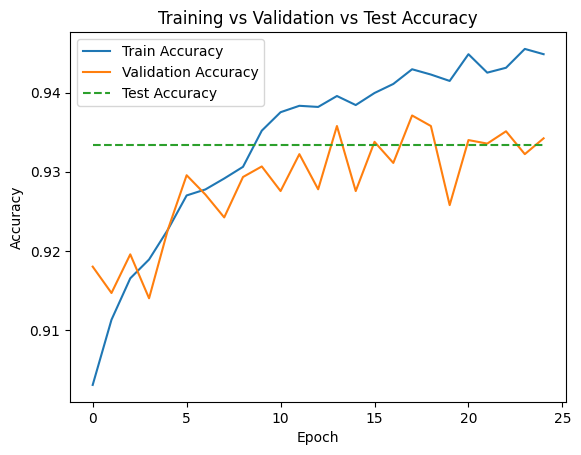

In [38]:
### ADD YOUR CODE HERE ###

#Train vs Test  vs Validation accuracy
import matplotlib.pyplot as plt


epochs = len(trainAcc_he_aug)

test_acc_line = [test_acc] * epochs

plt.figure()
plt.plot(trainAcc_he_aug, label='Train Accuracy')
plt.plot(valAcc_he_aug, label='Validation Accuracy')
plt.plot(test_acc_line, label='Test Accuracy', linestyle='--')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation vs Test Accuracy')
plt.legend()
plt.show()

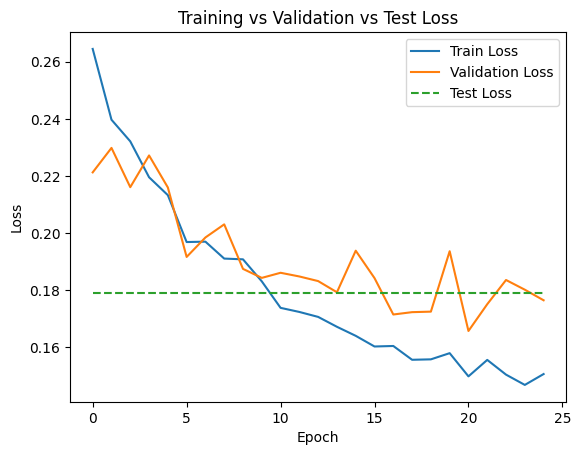

In [39]:

#Loss accuracy
test_loss_line = [test_loss] * epochs

plt.figure()
plt.plot(trainLoss_he_aug, label='Train Loss')
plt.plot(valLoss_he_aug, label='Validation Loss')
plt.plot(test_loss_line, label='Test Loss', linestyle='--')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation vs Test Loss')
plt.legend()
plt.show()

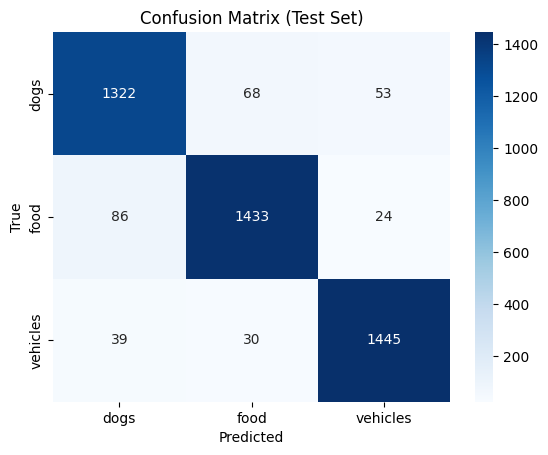

In [40]:
#Confusion Matrix

from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

cm = confusion_matrix(y_true, y_pred)

plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=dataset.classes,
            yticklabels=dataset.classes)

plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix (Test Set)')
plt.show()

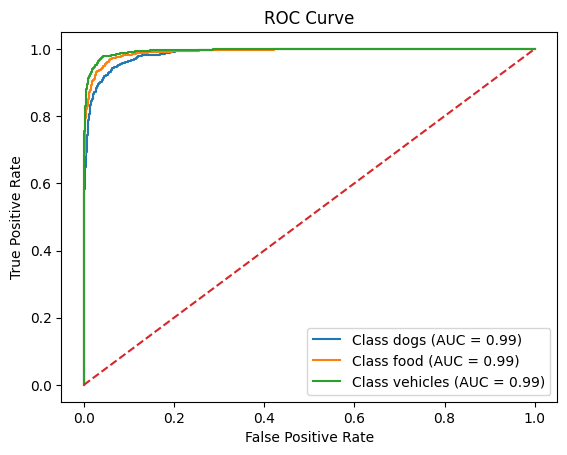

In [41]:
#ROC Curve

from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np

# Get probabilities
model_he.eval()
probs = []

with torch.no_grad():
    for x, _ in test_loader_aug:
        x = x.to(device)
        outputs = model_he(x)
        probs.extend(torch.softmax(outputs, dim=1).cpu().numpy())

probs = np.array(probs)

# Binarize labels
n_classes = len(dataset.classes)
y_true_bin = label_binarize(y_true, classes=list(range(n_classes)))

plt.figure()

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {dataset.classes[i]} (AUC = {roc_auc:.2f})')

plt.plot([0,1], [0,1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

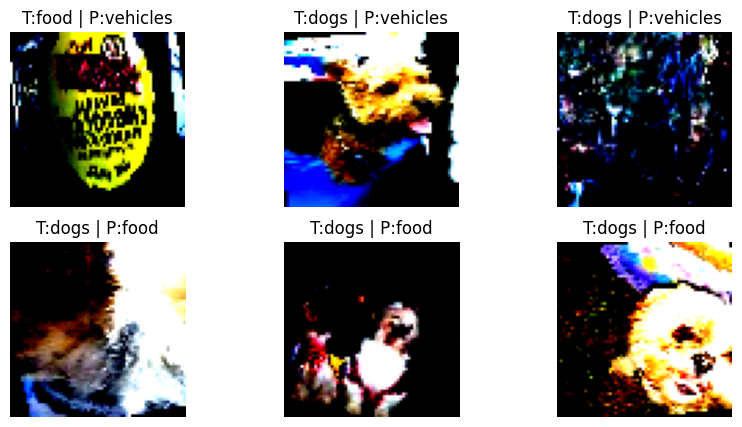

In [42]:
import random

model_he.eval()
misclassified = []

with torch.no_grad():
    for x, y in test_loader_aug:
        x, y = x.to(device), y.to(device)
        outputs = model_he(x)
        preds = outputs.argmax(1)

        for i in range(len(y)):
            if preds[i] != y[i]:
                misclassified.append((x[i].cpu(), y[i].cpu(), preds[i].cpu()))

# Show few examples
plt.figure(figsize=(10,5))
for i in range(min(6, len(misclassified))):
    img, true, pred = misclassified[i]
    img = img.permute(1,2,0)

    plt.subplot(2,3,i+1)
    plt.imshow(img)
    plt.title(f"T:{dataset.classes[true]} | P:{dataset.classes[pred]}")
    plt.axis('off')

plt.show()

Eror can be because of low pixel, poor lighting

In [43]:
torch.save(model_he.state_dict(), "best_vgg16_model.pth")

In [45]:
import os

print(os.listdir())

['.config', 'gdrive', 'best_model_he_aug.pth', 'cnn_dataset.zip', 'best_vgg16_model.pth', 'vehicles', 'dogs', 'food', 'cnn_dataset', 'sample_data']


## Step 3: Implementing ResNet

1. Implement residual blocks of ResNet.

In [46]:
import torch.nn as nn

class ResidualBlock(nn.Module):
  def __init__(self, in_channels, out_channels, stride=1):
    super(ResidualBlock, self).__init__()


    self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
    self.bn1 = nn.BatchNorm2d(out_channels)

    #Applying activation function
    self.relu = nn.ReLU(inplace=True)

    self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
    self.bn2 = nn.BatchNorm2d(out_channels)

    #If size of image changes , then make changes else keep as it is
    if stride != 1 or in_channels != out_channels:
      self.shortcut = nn.Sequential(
          nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
          nn.BatchNorm2d(out_channels)
      )
    else:
      self.shortcut = nn.Identity()

  def forward(self, x):
    output = self.relu(self.bn1(self.conv1(x)))
    output = self.bn2(self.conv2(output))
    output += self.shortcut(x)
    output = self.relu(output)
    return output




2. Assemble the ResNet-18 architecture.

In [47]:
from torchsummary import summary

In [48]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

class ResNet18(nn.Module):
    def __init__(self, numClasses, in_channels=3):  # specify input channels
        super(ResNet18, self).__init__()
        self.in_channels = 64  # for residual blocks

        # First conv layer
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, stride=1, padding=1, bias=False)  # 3x3 for small images
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.Identity()  # skip maxpool for small 64x64 images

        # Residual layers
        self.layer1 = self._make_layer(64, 2, stride=1)
        self.layer2 = self._make_layer(128, 2, stride=2)
        self.layer3 = self._make_layer(256, 2, stride=2)
        self.layer4 = self._make_layer(512, 2, stride=2)

        # Average pooling and fully connected
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, numClasses)

    def _make_layer(self, out_channels, num_blocks, stride):
        layers = []
        layers.append(ResidualBlock(self.in_channels, out_channels, stride))
        self.in_channels = out_channels
        for _ in range(1, num_blocks):
            layers.append(ResidualBlock(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x

# Example usage
'''model = ResNet18(numClasses=3, in_channels=3)  # RGB images, 3 classes
summary(model, input_size=(3, 64, 64))'''

'model = ResNet18(numClasses=3, in_channels=3)  # RGB images, 3 classes\nsummary(model, input_size=(3, 64, 64))'

3. Train the ResNet-18 model.

In [50]:
modelResnet = ResNet18(numClasses=3, in_channels=3).to(device)
summary(modelResnet, input_size=(3, 64, 64))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           1,728
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
          Identity-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
         Identity-10           [-1, 64, 64, 64]               0
             ReLU-11           [-1, 64, 64, 64]               0
    ResidualBlock-12           [-1, 64, 64, 64]               0
           Conv2d-13           [-1, 64, 64, 64]          36,864
      BatchNorm2d-14           [-1, 64,

4. Apply regularization techniques.

In [51]:
### ADD YOUR CODE HERE ###
import torch.optim as optim

optimizer_resnet = optim.Adam(
    modelResnet.parameters(),
    lr=0.003,
    weight_decay=1e-4
)

In [52]:
scheduler_resnet = optim.lr_scheduler.StepLR(
    optimizer_resnet,
    step_size=5,
    gamma=0.5
)

In [54]:
trainLoss_res, trainAcc_res, valLoss_res, valAcc_res = train_model_earlystop(
    modelResnet,
    train_loader_aug,
    val_loader_aug,
    optimizer_resnet,
    scheduler_resnet,
    epochs=25,
    patience=5
)

Epoch 1: TrainLoss=0.5007, ValLoss=0.4406, TrainAcc=0.8075, ValAcc=0.8316
Epoch 2: TrainLoss=0.4487, ValLoss=0.3828, TrainAcc=0.8261, ValAcc=0.8589
Epoch 3: TrainLoss=0.3905, ValLoss=0.3596, TrainAcc=0.8508, ValAcc=0.8653
Epoch 4: TrainLoss=0.3732, ValLoss=0.5101, TrainAcc=0.8596, ValAcc=0.8231
Epoch 5: TrainLoss=0.3447, ValLoss=0.4322, TrainAcc=0.8690, ValAcc=0.8264
Epoch 6: TrainLoss=0.2996, ValLoss=0.2796, TrainAcc=0.8873, ValAcc=0.8971
Epoch 7: TrainLoss=0.2921, ValLoss=0.2863, TrainAcc=0.8891, ValAcc=0.8938
Epoch 8: TrainLoss=0.2790, ValLoss=0.2781, TrainAcc=0.8960, ValAcc=0.8967
Epoch 9: TrainLoss=0.2723, ValLoss=0.2800, TrainAcc=0.8988, ValAcc=0.8996
Epoch 10: TrainLoss=0.2651, ValLoss=0.2385, TrainAcc=0.9003, ValAcc=0.9129
Epoch 11: TrainLoss=0.2332, ValLoss=0.2174, TrainAcc=0.9129, ValAcc=0.9220
Epoch 12: TrainLoss=0.2273, ValLoss=0.1989, TrainAcc=0.9156, ValAcc=0.9280
Epoch 13: TrainLoss=0.2192, ValLoss=0.1958, TrainAcc=0.9185, ValAcc=0.9276
Epoch 14: TrainLoss=0.2143, ValLos

5. Evaluation and analysis.

In [57]:
### ADD YOUR CODE HERE ###
'''test_loss_res, test_acc_res, prec_res, rec_res, f1_res, y_true_res, y_pred_res = evaluate_model(
    modelResnet, test_loader_aug
)

print("ResNet Test Acc:", test_acc_res)
print("Precision:", prec_res)
print("Recall:", rec_res)
print("F1:", f1_res)'''

from sklearn.metrics import precision_recall_fscore_support

# Get loss, accuracy, true labels, predicted labels
test_loss_res, test_acc_res, y_true_res, y_pred_res = evaluate_model(modelResnet, test_loader_aug)

# Compute precision, recall, F1
prec_res, rec_res, f1_res, _ = precision_recall_fscore_support(y_true_res, y_pred_res, average='weighted')

print("ResNet Test Acc:", test_acc_res)
print("Precision:", prec_res)
print("Recall:", rec_res)
print("F1:", f1_res)

ResNet Test Acc: 0.9428888888888889
Precision: 0.9434642968074293
Recall: 0.9428888888888889
F1: 0.942995919344009


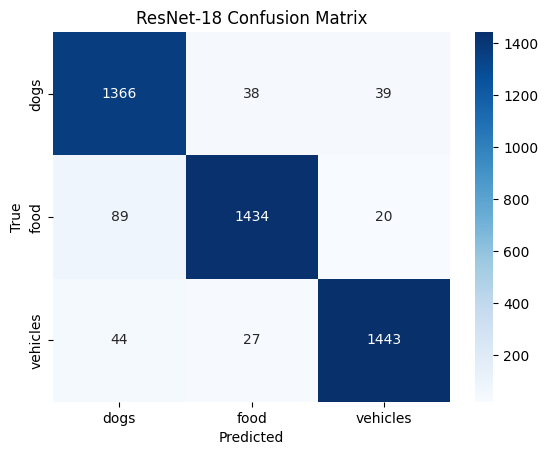

In [58]:
#Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true_res, y_pred_res)

plt.figure()
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=dataset.classes,
            yticklabels=dataset.classes)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("ResNet-18 Confusion Matrix")
plt.show()

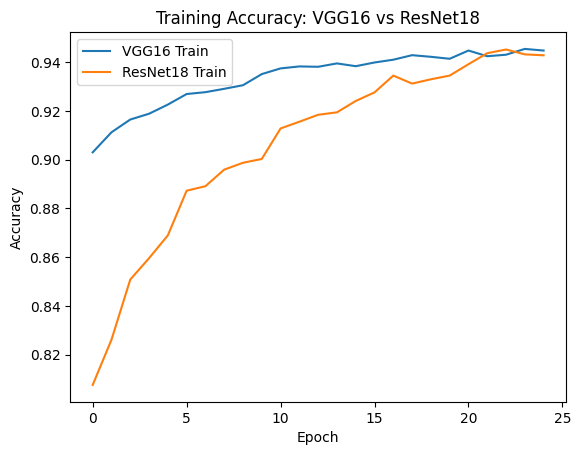

In [59]:
#Training accuracy comparison of both the models

epochs_vgg = len(trainAcc_he_aug)
epochs_res = len(trainAcc_res)

plt.figure()
plt.plot(range(epochs_vgg), trainAcc_he_aug, label='VGG16 Train')
plt.plot(range(epochs_res), trainAcc_res, label='ResNet18 Train')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training Accuracy: VGG16 vs ResNet18")
plt.legend()
plt.show()

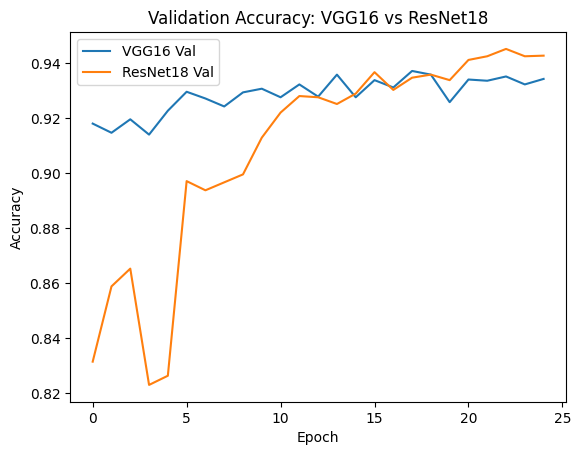

In [60]:
#Validation accuracy comparison of both the models

plt.figure()
plt.plot(range(epochs_vgg), valAcc_he_aug, label='VGG16 Val')
plt.plot(range(epochs_res), valAcc_res, label='ResNet18 Val')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Validation Accuracy: VGG16 vs ResNet18")
plt.legend()
plt.show()

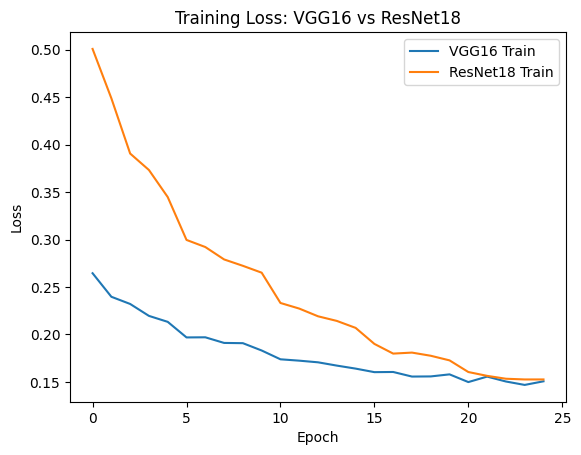

In [61]:
#Training loss comparison of both the models


plt.figure()
plt.plot(range(epochs_vgg), trainLoss_he_aug, label='VGG16 Train')
plt.plot(range(epochs_res), trainLoss_res, label='ResNet18 Train')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss: VGG16 vs ResNet18")
plt.legend()
plt.show()

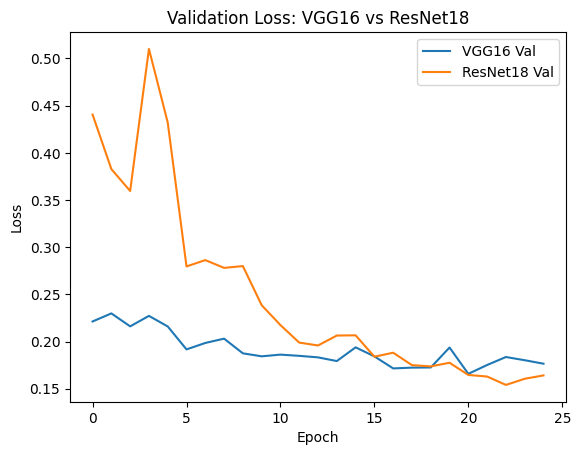

In [62]:
#Validation loss comparison of both the models


plt.figure()
plt.plot(range(epochs_vgg), valLoss_he_aug, label='VGG16 Val')
plt.plot(range(epochs_res), valLoss_res, label='ResNet18 Val')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation Loss: VGG16 vs ResNet18")
plt.legend()
plt.show()

6. Save the weights of the trained network.

In [65]:
### ADD YOUR CODE HERE ###

if test_acc_res > test_acc:
    torch.save(modelResnet.state_dict(), "best_model_resnet.pth")
    print("Saved ResNet as best model")
else:
    torch.save(model_he.state_dict(), "best_model_Vgg.pth")
    print("Saved VGG as best model")

Saved ResNet as best model


In [66]:
modelResnet.load_state_dict(torch.load("best_model_resnet.pth"))
modelResnet.eval()

ResNet18(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): Identity()
  (layer1): Sequential(
    (0): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (shortcut): Identity()
    )
    (1): ResidualBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64,

## Step 4: Discussion and conclusion

1. Explain the theoretical concepts behind VGG and ResNet.

<span style='color:green'>### YOUR ANSWER ###</span>



**VGG:**  
VGG was introduced by the Visual Geometry Group, hence the abbreviation associated with it. The main models are **VGG-16** and **VGG-19**. It works well by stacking convolution filters and introspecting every detail of the image so that it understands better over time. It is very simple to implement and works similarly to a CNN; the main difference is that we have more layers here comparatively. Afterward, we flatten the images and use them for classification. Normally, **ReLU** is used as the activation function. The main issue with VGG is that it can lead to the **vanishing gradient problem**.

**ResNet:**  
ResNet was originally introduced by **Kaiming He**. Deep networks generally perform well, but over iterating hidden layers can cause accuracy to drop, leading to the vanishing gradient problem. ResNet introduced the concept of **residual blocks** to mitigate this issue. Training is much better compared to VGG. **Batch Normalization** and **ReLU** are used as activation functions.

2. Discuss the impact of regularization and optimization techniques.

<span style='color:green'>### YOUR ANSWER ###</span>

**Regularisation** is mainly used to prevent overfitting in the model, basically adds penalty to the model to prevent it from learning the data
We basically have two important regularisation techniques which are Lasso and Ridge. In my assignment we have aslo used Dropout which basically drops or sets to 0 few of the neurons while training. I have also added data augmentation so that i can transform the image and it adds to more spatiality so that it can learn it better. Impact would be helps model try out different scenarios and reduce overfitting

For **Optimisation** techniques : We have mainly few ie Adam , SGD , and it adjusts the wieghts of the model over time and hence when the gradient descent is applied it learns over time so that we can find loss function over time. We also keep learning rate scheduler which adjusts learning rate over time. imapct would be helps in increasing the training time

3. Analyze the results, including all required graphs and metrics.

> Add blockquote



<span style='color:green'>### YOUR ANSWER ###</span>

### 3. Analyze the Results, Including All Required Graphs and Metrics

**Analysis of Results:**  
- After training the network, we evaluate **performance metrics** such as:  
  - **Accuracy** – Percentage of correctly classified samples.  
  - **Loss** – Measures how well the model fits the data; monitored during training and validation.  
  - **Precision, Recall, F1-Score** – Especially important for imbalanced datasets.  
  - **Confusion Matrix** – Provides insight into which classes are misclassified.

**Graphical Analysis:**  
- **Training vs. Validation Loss Curve:**  
  - Shows convergence of the model.  
  - Overfitting is indicated if validation loss increases while training loss decreases.  
- **Accuracy Curve:**  
  - Tracks improvement over epochs.  
  - Helps determine if the model is still learning or has plateaued.  
- **ROC Curve / AUC (if applicable):**  
  - Shows the trade-off between True Positive Rate and False Positive Rate.  
  - Higher AUC indicates better discriminative ability.  

**Observations:**  
- Compare training and validation curves to assess overfitting or underfitting.  
- Identify any patterns in the confusion matrix to see which classes are commonly misclassified.  
- Use metrics like F1-score to balance precision and recall in imbalanced datasets.  

**Conclusion:**  
- Results should confirm if the chosen architecture, optimization, and regularization techniques led to a robust and generalizable model.  
- Graphs and metrics together provide a **holistic understanding** of model performance.

4. Summarize your findings and discuss the advantages of residual connections.

> Add blockquote



<span style='color:green'>### YOUR ANSWER ###</span>



**Summary of Findings:**  
Below are the points that have been discussed above and just writing down as summary
- Deep networks can extract complex features but often face **vanishing/exploding gradient problems** as depth increases.  
- VGG uses a simple deep convolutional architecture,
- ResNet introduces residual blocks, enabling very deep networks to train efficiently without degradation.  
- Regularization techniques (like L1/L2, Dropout) improve generalization**, while optimization techniques (like SGD, Adam) improve training stability and convergence


**Advantages of Residual Connections:**  
1. Mitigates Vanishing Gradient Problem: Gradients can flow directly through identity shortcuts, allowing very deep networks to train.  
2. Compared to VGG or deep neural network model, i can have a better accuracy   
3. Better Feature Reuse: The shortcut connections let the network reuse features from earlier layers efficiently.



5. References.

<span style='color:green'>### YOUR ANSWER ###</span>
1) https://docs.pytorch.org/docs/stable/generated/torch.nn.AdaptiveAvgPool2d.html
2) https://docs.pytorch.org/docs/stable/nn.init.html


## Step 5: Deploy the model

Upload the video to UBBox and share the publicly available recording link in the Markdown cell below.